Keong Jo Hsi 1001685  
Homework 4 (Coding Part 1)

Required files which are not included:
- `trainfile.txt`
- `valfile.txt`
- jpg folder containing flowers dataset

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
import time
import copy
import math

%matplotlib notebook
from matplotlib import pyplot as plt
import PIL.Image as Image

In [2]:
def parsefile(f):
    return np.genfromtxt(f, dtype=None, encoding='utf-8')

In [3]:
class dataset_flowers(Dataset):

    def __init__(self, img_dir='/jpg/', transform=None, mode='train'):
        self.img_dir = img_dir
        self.transform = transform

        if mode == 'train':
            dataset = parsefile('trainfile.txt')
        elif mode == 'val':
            dataset = parsefile('valfile.txt')
        self.dataset = dataset

    def __getitem__(self, index):

        jpg, label = self.dataset[index]
        imgfile = os.path.join(self.img_dir, jpg)
        img = Image.open(imgfile).convert('RGB')

        if self.transform:
            augmented_img = self.transform(img)
        else:
            trans = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ])
            augmented_img = trans(img)

        return {'img': augmented_img, 'label': label}

    def __len__(self):
        return len(self.dataset)

#### Without Pretraining

In [4]:
device = torch.device('cuda:0')
model = models.resnet18(pretrained=False).to(device)
optimizer = optim.SGD(params=model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

In [5]:
datasets = {x: dataset_flowers(mode=x) for x in ['train', 'val']}
batchsize = 12
dl = {x: DataLoader(dataset=datasets[x], batch_size=batchsize, shuffle=True) for x in ['train', 'val']}
dataset_length = {x: len(datasets[x]) for x in ['train', 'val']}
total_iter = {x: math.ceil(dataset_length[x] / batchsize) for x in ['train', 'val']}
num_epochs = 5

In [6]:
since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    
    # each epoch has a training and a validation phase
    for phase in ['train', 'val']:
        iteration = 0
        if phase == 'train':
            model.train() 
        else:
            model.eval()
            
        running_loss = 0.0
        running_corrects = 0
        
        for data_dict in dl[phase]:
            iteration += 1
            data = data_dict['img'].to(device)  # [5,3,244,244], FloatTensor
            label = data_dict['label'].long().to(device) # [5], LongTensor

            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                output = model(data) # [5,1000], FloatTensor
            #     print('output', output)

                pred = (torch.argmax(output, dim=1)) # [5], FloatTensor
            #     print('pred', pred)
            #     print('label', label)

                loss = criterion(output, label)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # minibatch_loss * minibatch_size
            running_loss += loss.item() * label.shape[0]
            running_corrects += sum(torch.eq(pred,label)).item()
            
            print('iter: {}/{}, running loss = {:.4f}'.format(iteration, total_iter[phase], running_loss), end='\r')

        epoch_loss = running_loss / dataset_length[phase]
        epoch_acc = running_corrects / dataset_length[phase]
        
        print('Phase: {} \tLoss: {:.4f} \tAccuracy: {:.4f}'.format(
                phase.capitalize(), epoch_loss, epoch_acc))
        
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            
    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
print('Best val acc: {:4f}'.format(best_acc))
model.load_state_dict(best_model_wts)

Epoch 0/4
Phase: Train 	Loss: 4.4263 	Accuracy: 0.0923
Phase: Val 	Loss: 3.6187 	Accuracy: 0.1307

Epoch 1/4
Phase: Train 	Loss: 3.4288 	Accuracy: 0.1676
Phase: Val 	Loss: 3.0156 	Accuracy: 0.2426

Epoch 2/4
Phase: Train 	Loss: 3.0442 	Accuracy: 0.2414
Phase: Val 	Loss: 2.8226 	Accuracy: 0.2998

Epoch 3/4
Phase: Train 	Loss: 2.7585 	Accuracy: 0.2968
Phase: Val 	Loss: 2.5907 	Accuracy: 0.3276

Epoch 4/4
Phase: Train 	Loss: 2.5565 	Accuracy: 0.3371
Phase: Val 	Loss: 2.4799 	Accuracy: 0.3717

Training complete in 10m 42s
Best val acc: 0.371732


#### With Pretraining

In [4]:
device = torch.device('cuda:0')
model = models.resnet18(pretrained=True).to(device)
optimizer = optim.SGD(params=model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

In [5]:
datasets = {x: dataset_flowers(mode=x) for x in ['train', 'val']}
batchsize = 12
dl = {x: DataLoader(dataset=datasets[x], batch_size=batchsize, shuffle=True) for x in ['train', 'val']}
dataset_length = {x: len(datasets[x]) for x in ['train', 'val']}
total_iter = {x: math.ceil(dataset_length[x] / batchsize) for x in ['train', 'val']}
num_epochs = 5

In [6]:
since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    
    # each epoch has a training and a validation phase
    for phase in ['train', 'val']:
        iteration = 0
        if phase == 'train':
            model.train() 
        else:
            model.eval()
            
        running_loss = 0.0
        running_corrects = 0
        
        for data_dict in dl[phase]:
            iteration += 1
            data = data_dict['img'].to(device)  # [5,3,244,244], FloatTensor
            label = data_dict['label'].long().to(device) # [5], LongTensor

            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                output = model(data) # [5,1000], FloatTensor
            #     print('output', output)

                pred = (torch.argmax(output, dim=1)) # [5], FloatTensor
            #     print('pred', pred)
            #     print('label', label)

                loss = criterion(output, label)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # minibatch_loss * minibatch_size
            running_loss += loss.item() * label.shape[0]
            running_corrects += sum(torch.eq(pred,label)).item()
            
            print('iter: {}/{}, running loss = {:.4f}'.format(iteration, total_iter[phase], running_loss), end='\r')

        epoch_loss = running_loss / dataset_length[phase]
        epoch_acc = running_corrects / dataset_length[phase]
        
        print('Phase: {} \tLoss: {:.4f} \tAccuracy: {:.4f}'.format(
                phase.capitalize(), epoch_loss, epoch_acc))
        
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            
    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
print('Best val acc: {:4f}'.format(best_acc))
model.load_state_dict(best_model_wts)

Epoch 0/4
Phase: Train 	Loss: 2.0927 	Accuracy: 0.6056
Phase: Val 	Loss: 0.5006 	Accuracy: 0.8758

Epoch 1/4
Phase: Train 	Loss: 0.2835 	Accuracy: 0.9414
Phase: Val 	Loss: 0.2725 	Accuracy: 0.9314

Epoch 2/4
Phase: Train 	Loss: 0.1002 	Accuracy: 0.9863
Phase: Val 	Loss: 0.2127 	Accuracy: 0.9420

Epoch 3/4
Phase: Train 	Loss: 0.0498 	Accuracy: 0.9961
Phase: Val 	Loss: 0.1877 	Accuracy: 0.9453

Epoch 4/4
Phase: Train 	Loss: 0.0354 	Accuracy: 0.9974
Phase: Val 	Loss: 0.1992 	Accuracy: 0.9502

Training complete in 10m 27s
Best val acc: 0.950163


#### Pretraining with last layer removed

In [4]:
device = torch.device('cuda:0')
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized as opposed to before
optimizer = optim.SGD(params=model.fc.parameters(), lr=1e-2)

In [5]:
datasets = {x: dataset_flowers(mode=x) for x in ['train', 'val']}
batchsize = 12
dl = {x: DataLoader(dataset=datasets[x], batch_size=batchsize, shuffle=True) for x in ['train', 'val']}
dataset_length = {x: len(datasets[x]) for x in ['train', 'val']}
total_iter = {x: math.ceil(dataset_length[x] / batchsize) for x in ['train', 'val']}
num_epochs = 5

In [ ]:
since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    
    # each epoch has a training and a validation phase
    for phase in ['train', 'val']:
        iteration = 0
        if phase == 'train':
            model.train() 
        else:
            model.eval()
            
        running_loss = 0.0
        running_corrects = 0
        
        for data_dict in dl[phase]:
            iteration += 1
            data = data_dict['img'].to(device)  # [5,3,244,244], FloatTensor
            label = data_dict['label'].long().to(device) # [5], LongTensor

            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                output = model(data) # [5,1000], FloatTensor
            #     print('output', output)

                pred = (torch.argmax(output, dim=1)) # [5], FloatTensor
            #     print('pred', pred)
            #     print('label', label)

                loss = criterion(output, label)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # minibatch_loss * minibatch_size
            running_loss += loss.item() * label.shape[0]
            running_corrects += sum(torch.eq(pred,label)).item()
            
            print('iter: {}/{}, running loss = {:.4f}'.format(iteration, total_iter[phase], running_loss), end='\r')

        epoch_loss = running_loss / dataset_length[phase]
        epoch_acc = running_corrects / dataset_length[phase]
        
        print('Phase: {} \tLoss: {:.4f} \tAccuracy: {:.4f}'.format(
                phase.capitalize(), epoch_loss, epoch_acc))
        
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            
    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
print('Best val acc: {:4f}'.format(best_acc))
model.load_state_dict(best_model_wts)

#### Plot of validation accuracies

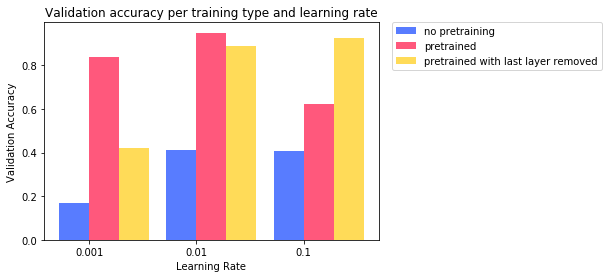

In [13]:
index = np.arange(3)

not_pretrained = (0.1707, 0.4101, 0.406)
pretrained = (0.8398, 0.9501, 0.623)
finetuned = (0.4191, 0.8888, 0.924)
bar_width = 0.28

fig, ax = plt.subplots()

rects1 = ax.bar(index, not_pretrained, bar_width, color='#587cff', label='no pretraining', align='center')
rects2 = ax.bar(index+bar_width, pretrained, bar_width, color='#ff587c', label='pretrained', align='center')
rects3 = ax.bar(index+(2*bar_width), finetuned, bar_width, color='#ffdb58', label='pretrained with last layer removed', align='center')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Validation Accuracy')
ax.set_title('Validation accuracy per training type and learning rate')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('0.001', '0.01', '0.1'))
ax.legend(bbox_to_anchor=(1.04,1), borderaxespad=0);

Training was performed over 5 epochs per learning rate and training type. All data was resized to 224 on its shorter side and centre-cropped to 224x224. Pretraining the model and afterwards training only the last layer yields better accuracy as learning rate increases. On the other hand, pretraining and then training all layers yields a poorer accuracy as learning rate or epoch size increases, since too much training will override the pretrained weights, resulting in an effect similar to a model without pretraining. 